# Plan of Action

In [2]:
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import sys
from pathlib import Path

# Add parent directory to sys.path
parent_dir = Path("..").resolve()
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
import itertools
from sklearn.metrics import confusion_matrix
from common_utils import *
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

np.random.seed(42)
tf.random.set_seed(42)

2025-04-02 10:08:57.749760: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 10:08:57.795120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-02 10:08:57.795167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-02 10:08:57.796514: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 10:08:57.803819: I tensorflow/core/platform/cpu_feature_guar

## Import Dataset

In [6]:

image_paths_csv = pd.read_csv("./processed_data/image_paths.csv")
paths_train_df, paths_val_df, paths_test_df = split_data(image_paths_csv)


## Organize Dataset

In [7]:

paths_train_df_list = list(paths_train_df['path'])
paths_train_labels_list = list(paths_train_df['age_bin'])


paths_test_df_list = list(paths_test_df['path'])
paths_test_labels_list = list(paths_test_df['age_bin'])


In [8]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_aug_filenames_tensor = tf.constant(paths_train_df_list)
train_aug_labels_tensor = tf.constant(paths_train_labels_list)

test_filenames_tensor = tf.constant(paths_test_df_list)
test_labels_tensor = tf.constant(paths_test_labels_list)


2025-04-02 10:08:59.553217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43622 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:63:00.0, compute capability: 8.9


# Image Greyscale Function

In [9]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 13

def _parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [10]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

# CNN Architecture

In [11]:
# Defining the architecture of the sequential neural network.

model=build_sequential_cnn_model(
    channels=1,
    dropout_rate=0,
    task="classification",
    num_classes=13,
    num_conv_layers=4,
    conv_filters=[32, 64, 128, 256],
    kernel_size=3,
    activation="relu",
    num_dense_layers=1,
    dense_units=[132],
    output_activation="softmax"
)

final_cnn = Sequential([
    Input(shape=(200, 200, 1)),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    AveragePooling2D(pool_size=(2,2)),

    Conv2D(filters=64, kernel_size=3, activation='relu'),
    AveragePooling2D(pool_size=(2,2)),

    Conv2D(filters=128, kernel_size=3, activation='relu'),
    AveragePooling2D(pool_size=(2,2)),

    Conv2D(filters=256, kernel_size=3, activation='relu'),
    AveragePooling2D(pool_size=(2,2)),

    GlobalAveragePooling2D(),
    Dense(132, activation='relu'),
    Dense(13, activation='softmax')
])
final_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d_4 (Avera  (None, 99, 99, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_5 (Avera  (None, 48, 48, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_6 (Avera  (None, 23, 23, 128)      

In [13]:

model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',  # Fixed loss function.
        metrics=['accuracy']
    )
final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Fitting

In [17]:
# Fitting the above created CNN model.

final_cnn_history = final_cnn.fit(train_aug_dataset,
                                  batch_size=512,
                                  validation_data=test_dataset,
                                  epochs=120,
                                  verbose=2,
                                  # callbacks=[tensorboard, checkpoint],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )





Epoch 1/60
14/14 - 4s - loss: 5.5227 - accuracy: 0.1217 - val_loss: 2.4601 - val_accuracy: 0.1421 - 4s/epoch - 280ms/step
Epoch 2/60
14/14 - 2s - loss: 2.4445 - accuracy: 0.1650 - val_loss: 2.4505 - val_accuracy: 0.1421 - 2s/epoch - 155ms/step
Epoch 3/60
14/14 - 2s - loss: 2.4372 - accuracy: 0.1779 - val_loss: 2.4297 - val_accuracy: 0.2163 - 2s/epoch - 153ms/step
Epoch 4/60
14/14 - 2s - loss: 2.4182 - accuracy: 0.1924 - val_loss: 2.4303 - val_accuracy: 0.1588 - 2s/epoch - 154ms/step
Epoch 5/60
14/14 - 2s - loss: 2.4022 - accuracy: 0.1933 - val_loss: 2.3891 - val_accuracy: 0.2153 - 2s/epoch - 155ms/step
Epoch 6/60
14/14 - 2s - loss: 2.3567 - accuracy: 0.2303 - val_loss: 2.3416 - val_accuracy: 0.2372 - 2s/epoch - 154ms/step
Epoch 7/60
14/14 - 2s - loss: 2.3306 - accuracy: 0.2329 - val_loss: 2.3328 - val_accuracy: 0.2403 - 2s/epoch - 154ms/step
Epoch 8/60
14/14 - 2s - loss: 2.3026 - accuracy: 0.2442 - val_loss: 2.2756 - val_accuracy: 0.2330 - 2s/epoch - 160ms/step
Epoch 9/60
14/14 - 2s - 

In [16]:
history=model.fit(
        train_aug_dataset,
        batch_size=512,
        validation_data=test_dataset,
        epochs=120,
        verbose=2,
        shuffle=False
    )

Epoch 1/60


2025-04-02 10:09:29.824729: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-04-02 10:09:32.200991: I external/local_xla/xla/service/service.cc:168] XLA service 0x7c1ea9939550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-02 10:09:32.201061: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-04-02 10:09:32.208357: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743588572.317375    6901 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 - 17s - loss: 5.2671 - accuracy: 0.1074 - val_loss: 2.4962 - val_accuracy: 0.1578 - 17s/epoch - 1s/step
Epoch 2/60
14/14 - 2s - loss: 2.4568 - accuracy: 0.1561 - val_loss: 2.4541 - val_accuracy: 0.2278 - 2s/epoch - 148ms/step
Epoch 3/60
14/14 - 2s - loss: 2.4279 - accuracy: 0.1821 - val_loss: 2.4795 - val_accuracy: 0.1630 - 2s/epoch - 154ms/step
Epoch 4/60
14/14 - 2s - loss: 2.4369 - accuracy: 0.1899 - val_loss: 2.4527 - val_accuracy: 0.1693 - 2s/epoch - 150ms/step
Epoch 5/60
14/14 - 2s - loss: 2.3871 - accuracy: 0.2100 - val_loss: 2.3840 - val_accuracy: 0.2069 - 2s/epoch - 147ms/step
Epoch 6/60
14/14 - 2s - loss: 2.3639 - accuracy: 0.2297 - val_loss: 2.6032 - val_accuracy: 0.1567 - 2s/epoch - 153ms/step
Epoch 7/60
14/14 - 2s - loss: 2.3694 - accuracy: 0.2221 - val_loss: 2.3130 - val_accuracy: 0.2194 - 2s/epoch - 154ms/step
Epoch 8/60
14/14 - 2s - loss: 2.2885 - accuracy: 0.2442 - val_loss: 2.2958 - val_accuracy: 0.2309 - 2s/epoch - 149ms/step
Epoch 9/60
14/14 - 2s - loss: 2.2269

# Checking Model Performance

In [ ]:
histories=[]
histories.insert(final_cnn_history)
histories.insert(history)

In [21]:
df_list = []
for i, hist in enumerate(histories):
    epochs = range(1, len(hist.history['loss']) + 1)
    df = pd.DataFrame({
        'model_object': model if hist==history else final_cnn_history,
        'epoch': list(epochs),
        'loss': hist.history['loss'],
        'val_loss': hist.history['val_loss'],
        'accuracy': hist.history['accuracy'],
        'val_accuracy': hist.history['val_accuracy']
    })
    df['model'] = f"Model_{i+1}"
    df_list.append(df)

# Combine the DataFrames into one
df_combined = pd.concat(df_list, ignore_index=True)
df_combined


In [ ]:
models = df_combined['model'].unique()


Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

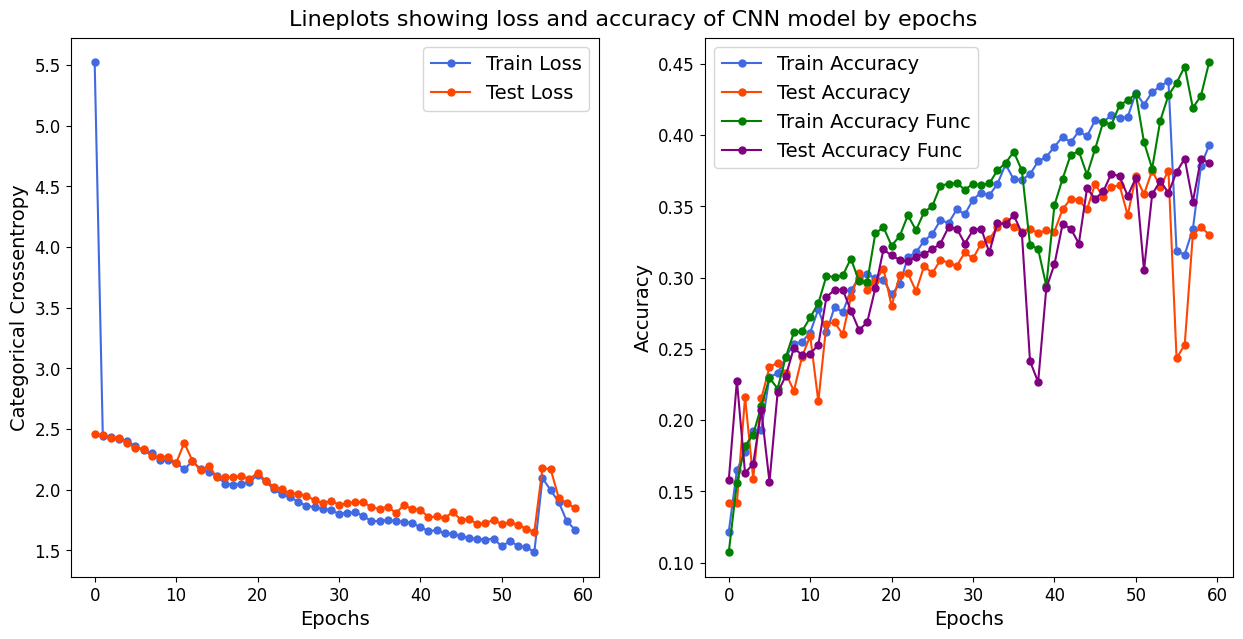

In [23]:

# Create subplots: one row per model and two columns (loss and accuracy)
fig, axes = plt.subplots(nrows=len(models), ncols=2, figsize=(15, 5 * len(models)))

# Ensure axes is 2D even if there is only one model
if len(models) == 1:
    axes = np.array([axes])

for i, model in enumerate(models):
    # Filter the dataframe for this model
    df_model = df_combined[df_combined['model'] == model]
    # Pick the top 10 rows with the highest training accuracy
    df_top10 = df_model.nlargest(10, 'accuracy').sort_values('epoch')
    
    # Left subplot: Loss curves
    ax_loss = axes[i, 0]
    ax_loss.plot(df_top10['epoch'], df_top10['loss'], label='Train Loss', marker='o')
    ax_loss.plot(df_top10['epoch'], df_top10['val_loss'], label='Test Loss', marker='o')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title(f'{model} - Loss')
    ax_loss.legend()
    
    # Right subplot: Accuracy curves
    ax_acc = axes[i, 1]
    ax_acc.plot(df_top10['epoch'], df_top10['accuracy'], label='Train Accuracy', marker='o')
    ax_acc.plot(df_top10['epoch'], df_top10['val_accuracy'], label='Test Accuracy', marker='o')
    ax_acc.set_xlabel('Epoch')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.set_title(f'{model} - Accuracy')
    ax_acc.legend()

plt.tight_layout()
plt.show()


In [24]:

for i, model in enumerate(models):
    model_score = model['model_object'].evaluate(test_dataset,verbose=1)
    model_labels = model['model_object'].metrics_names
    print(f'Func model {model_labels[0]} \t= {round(model_score[0], 3)}')
    print(f'Func model {model_labels[1]} \t= {round(model_score[1], 3)}')
    

2/2 [==============================] - 0s 67ms/step - loss: 1.6971 - accuracy: 0.3804


### Plotting Confusion Matrix

In [ ]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'./output/{export_as}.png', bbox_inches='tight');

In [30]:
# Generating predictions from the model above.
cm_plot_labels = ['1-2', '3-5', '6-8', '9-12', '13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85+']

for i, model in enumerate(models):
    model_pred = model['model_object'].predict(test_dataset)
    model_pred = model_pred.argmax(axis=-1)
    conf_mat = confusion_matrix(paths_test_labels_list, model_pred)
    plt.figure(figsize=(16,8))
    plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                          title="Confusion Matrix based on predictions from CNN model",
                          export_as="final_cnn_conf_mat_norm"
                         )
    plt.show()




1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 53ms/step
